In [300]:
import simplified_env as env
from utils import plot_heatmap
import utils
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np

#automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Parameters

In [241]:
epsilon = 0.00001
starting_grid = np.array([0,1,0,0,0,0,0])

## Environment

In [242]:
environment = env.env(starting_grid=starting_grid)

Environment Ready.


In [243]:
display(environment.probability_matrix)

array([[0.6, 0.4, 0. , 0. , 0. , 0. , 0. ],
       [0.4, 0.2, 0.4, 0. , 0. , 0. , 0. ],
       [0. , 0.4, 0.2, 0.4, 0. , 0. , 0. ],
       [0. , 0. , 0.4, 0.2, 0.4, 0. , 0. ],
       [0. , 0. , 0. , 0.4, 0.2, 0.4, 0. ],
       [0. , 0. , 0. , 0. , 0.4, 0.2, 0.4],
       [0. , 0. , 0. , 0. , 0. , 0.4, 0.6]])

In [244]:
display( environment.starting_grid )

array([0, 1, 0, 0, 0, 0, 0])

## Experiment

In [245]:
old_result = environment.starting_grid
result = np.matmul(environment.starting_grid, environment.probability_matrix)

#heatmap_series = [plot_heatmap(old_result),plot_heatmap(result)]
results_series = [old_result,result]

while np.max(np.abs(result - old_result)) > epsilon:
    old_result = result
    result = np.matmul(result, environment.probability_matrix)

    #heatmap_series.append( plot_heatmap(result) )
    results_series.append(result)

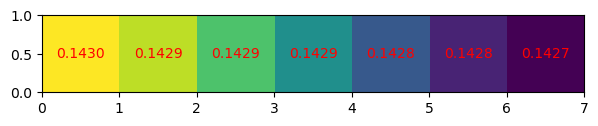

In [246]:
fig, ax = plt.subplots(figsize=(7,1))

def update(frame):
    cmap = plt.get_cmap('viridis')
    ax.clear()
    result = results_series[frame]
    normed_values = (result - np.min(result)) / (np.max(result) - np.min(result))

    for i, value in enumerate(result):
        plt.text(i + 0.5, 0.5, f'{value:.4f}', color='red', ha='center', va='center')

    ax.imshow(normed_values.reshape(1, -1), cmap=cmap, aspect='auto', extent=[0, len(result), 0, 1])

ani = FuncAnimation(fig, update, frames=len(results_series), interval=500, repeat=False)

HTML(ani.to_jshtml())

In [247]:
print(result)

[0.14296683 0.1429451  0.14290596 0.14285714 0.14280833 0.14276918
 0.14274746]


### Episode Sampling

In [248]:
episode = environment.sample_episode(10)    
print( episode )

[1, 0, 0, 1, 0, 1, 1, 2, 1, 0]


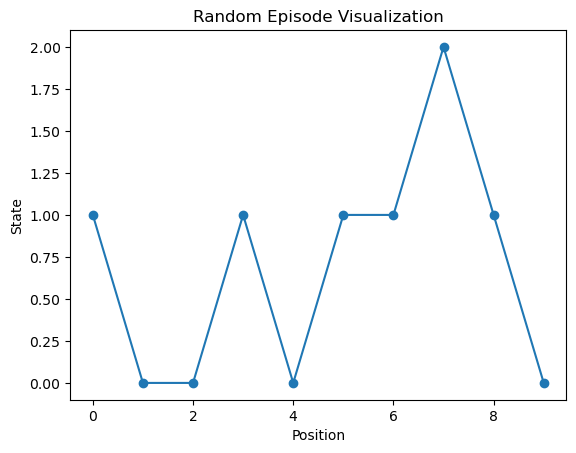

In [249]:
plt.plot( episode, marker='o')
plt.xlabel('Position')
plt.ylabel('State')
plt.title('Random Episode Visualization')
plt.show()

# Rewards

In [250]:
utils.return_function(episode, environment.rewards, environment.DISCOUNT_FACTOR)

0.814453125

### Computing the value function

Estimated by simulation

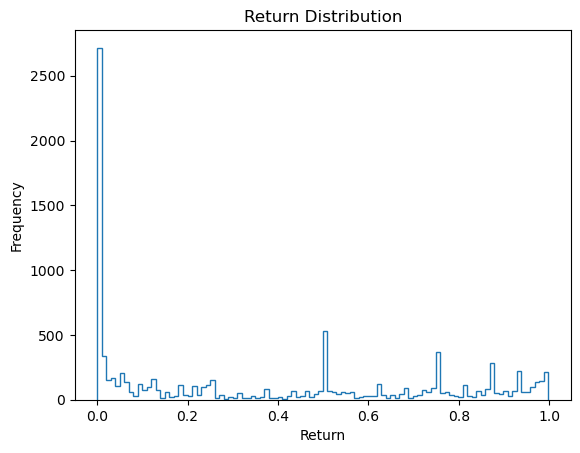

In [251]:
returns = []
for i in range(10000):
    episode = environment.sample_episode(10)
    returns.append( utils.return_function(episode, environment.rewards, environment.DISCOUNT_FACTOR) )

plt.hist(returns, bins=100, histtype='step')
plt.xlabel('Return')
plt.ylabel('Frequency')
plt.title('Return Distribution')
plt.show()

In [301]:
returns = {}
for s in tqdm(environment.states):
    returns[s.number] = []
    environment.starting_state = s
    for i in range(10000):
        episode = environment.sample_episode(100)
        returns[s.number].append( utils.return_function(episode, environment.rewards, environment.DISCOUNT_FACTOR) )


100%|██████████| 7/7 [03:10<00:00, 27.19s/it]


In [304]:
mean_returns = [np.mean(returns[s.number]) for s in environment.states]   
mean_returns

[1.5354603919506127,
 0.36825338685541853,
 0.13441288070592777,
 0.21450659456565468,
 0.8484099911590427,
 3.589911876498819,
 15.309646294521915]

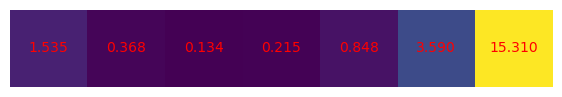

In [305]:
utils.plot_heatmap(mean_returns)

Bellman Equation

$V = (I - \gamma P)^{-1} R$

In [260]:
r = environment.rewards
r

[1, 0, 0, 0, 0, 0, 10]

In [261]:
p = environment.probability_matrix
identity = np.identity(p.shape[0])

In [287]:
v = (np.linalg.inv(identity - environment.DISCOUNT_FACTOR * p) @ r)

In [290]:
v

array([ 1.53426666,  0.3699333 ,  0.13043318,  0.21701603,  0.84613895,
        3.59060924, 15.31160264])

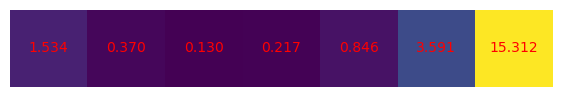

In [291]:
utils.plot_heatmap(v)

Power Iteration

$V_k(s) = (R + \gamma P) V_{k-1}$

In [292]:
v_pi = {}
v_pi[0] = [0] * len(r)
r = environment.rewards
p = environment.probability_matrix
gamma = environment.DISCOUNT_FACTOR

v_pi[0]

[0, 0, 0, 0, 0, 0, 0]

In [293]:
v_pi[1] = (r + gamma * p @ v_pi[0])
v_pi[1]

i = 1
while np.max(np.abs(v_pi[i] - v_pi[i-1])) > epsilon:
    v_pi[i+1] = (r + gamma * p @ v_pi[i])
    i += 1

In [294]:
v_pi[i]

array([ 1.53426245,  0.36992875,  0.130428  ,  0.21701004,  0.84613216,
        3.5906018 , 15.31159484])

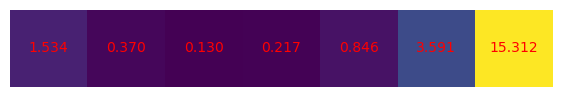

In [295]:
utils.plot_heatmap(v_pi[i])